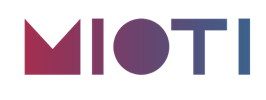
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Machine Learning</center>

# Challenge S6: Reconocimiento facial

##  Nombre: Pablo Sagrera

## Objetivos

El objetivo de este challenge es evaluar distintos clasificadores sobre un dataset de reconocimiento facial.

## Configuración del entorno

In [1]:
%matplotlib inline

from pylab import *
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC

También vamos a cargar algunas funciones que nos resultarán interesantes.

In [2]:
def print_faces(images, target, top_n):
    '''Dibuja las imágenes de las caras'''
    
    # set up the figure size in inches
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(top_n):
        # plot the images in a matrix of 20x20
        p = fig.add_subplot(20, 20, i + 1, xticks=[], yticks=[])
        p.imshow(images[i], cmap=plt.cm.bone)
        
        # label the image with the target value
        #p.text(0, 14, str(target[i]), color="red")
        p.text(1, 60, str(i), color="black", size=15)
        p.text(0, 60, str(i), color="yellow", size=15)

## Dataset

Esta vez utilizaremos un dataset de caras para realizar un algoritmo de reconocimiento facial.

In [3]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()

In [4]:
faces.keys()

dict_keys(['data', 'images', 'target', 'DESCR'])

In [5]:
print(faces.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

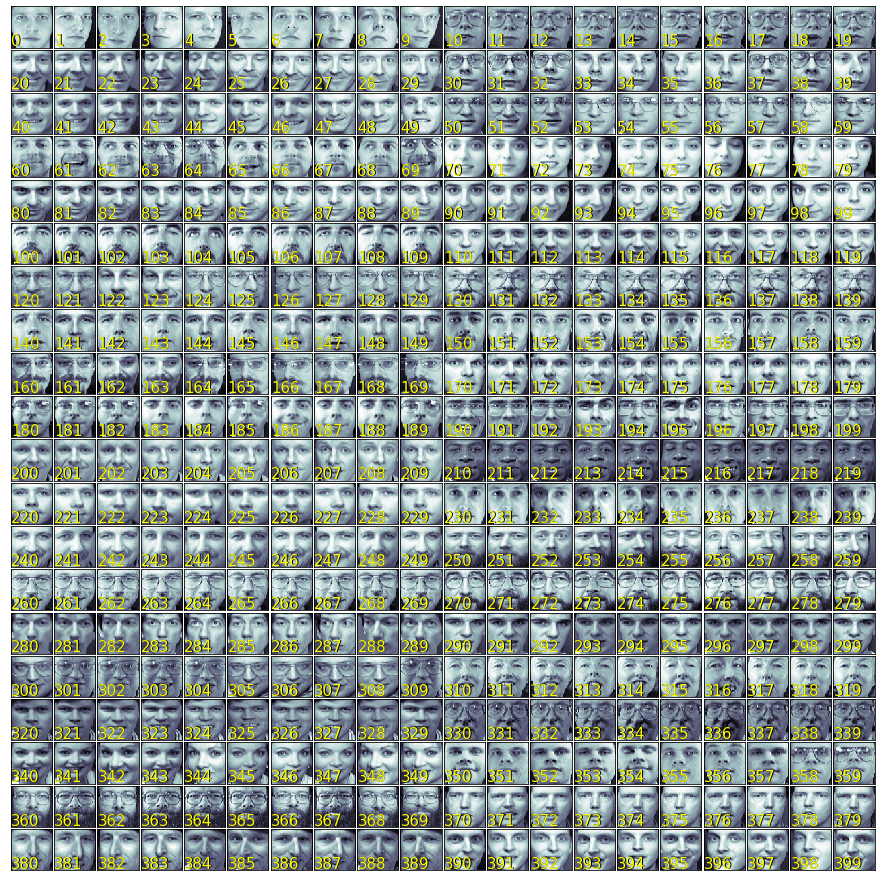

In [6]:
print_faces(faces.images, faces.target, 400)

### Atributos disponibles (X)

Asignamos la variable data a la variable X

In [7]:
dataset_X = faces.data

In [8]:
dataset_X *= 255

In [9]:
dataset_X.shape

(400, 4096)

In [10]:
dataset_X[0]

array([ 79.02893 ,  93.78099 , 106.42561 , ...,  38.987602,  41.095043,
        40.041325], dtype=float32)

In [11]:
import scipy
print(scipy.stats.describe(dataset_X[0]))

DescribeResult(nobs=4096, minmax=(21.074379, 223.38843), mean=162.39595, variance=1451.6178, skewness=-1.9089242219924927, kurtosis=3.2785653690113357)


### Variable objetivo (y)

En este caso, estamos ante un problema de clasificación, la variable a predecir es la persona a la que pertenece cada fotografía de un conjunto de 40 personas.

In [12]:
dataset_y = faces.target

In [13]:
dataset_y.shape

(400,)

In [14]:
print(dataset_y)

[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9
  9  9  9  9 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 14 14 14 14
 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16
 16 16 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 19 19
 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21
 21 21 21 21 22 22 22 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23
 24 24 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 25 25 26 26 26 26
 26 26 26 26 26 26 27 27 27 27 27 27 27 27 27 27 28 28 28 28 28 28 28 28
 28 28 29 29 29 29 29 29 29 29 29 29 30 30 30 30 30 30 30 30 30 30 31 31
 31 31 31 31 31 31 31 31 32 32 32 32 32 32 32 32 32

Vamos a simplificar el problema y convertirlo en detectar gente con gafas y gente sin gafas. Como el tamaño del dataset es pequeño (sólo 400 instancias) vamos a reducirlo.

Buscamos a mano la gente con gafas y reclasificamos el vector `y`.

In [15]:
glasses = [(10, 19), (30, 32), (37, 38), (50, 59), (63, 64),
           (69, 69), (120, 121), (124, 129), (130, 139), (160, 161),
           (164, 169), (180, 182), (185, 185), (189, 189), (190, 192),
           (194, 194), (196, 199), (260, 269), (270, 279), (300, 309),
           (330, 339), (358, 359), (360, 369)]

In [16]:
transformed_dataset_y = np.zeros(len(dataset_y), dtype=np.int16) 
for g in glasses:
    for i in range(g[0], g[1] + 1):
        transformed_dataset_y[i] = 1
        
print(transformed_dataset_y)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0
 1 0 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## Preprocesado de los datos

Examina los datos de entrenamiento y analiza si es necesario realizar algún preprocesamiento sobre los datos. Si es que sí aplicala.

* Variables que son enumerados
* Valores nulos
* Rango y escalado de los datos

In [17]:
# Revision del tipo de dato en el dataset
dataset_X.dtype

dtype('float32')

In [18]:
# Revision de la dimension del dataset
dataset_X.shape

(400, 4096)

In [19]:
# Revision de valores nulos
pd.DataFrame(dataset_X).isnull().any().sum()

0

In [20]:
# Revision de rangos (Valor mas alto del dataset)
(pd.DataFrame(dataset_X).max()).max()

255.0

In [21]:
(pd.DataFrame(dataset_X).max()).min()

138.0371856689453

In [22]:
(pd.DataFrame(dataset_X).min()).max()

118.01653289794922

In [23]:
# Revision de rangos (Valor mas pequeño del dataset)
(pd.DataFrame(dataset_X).min()).min()

0.0

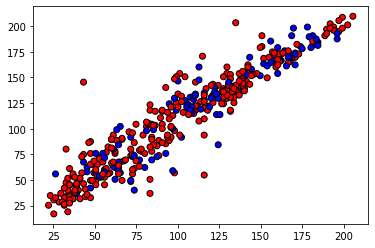

In [24]:
# Mejor observar los rangos con un scatter plot
def dibuja_dataset(X, y):  
    from matplotlib.colors import ListedColormap
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.scatter(X[:,0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')
    
dibuja_dataset(dataset_X, transformed_dataset_y)

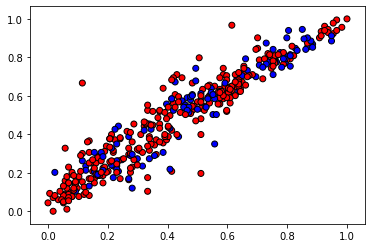

In [25]:
# Como el rango de valores del dataset va desde 0 hasta 255, es recomendable rescalar el dataset
# Utilizaremos el MinMaxScaler, para llevar el nuevo rango entre 0 y 1

from sklearn.preprocessing import MinMaxScaler

def eval_scaler(scaler, X, y):
    scaler.fit(X)
    scaled_X = scaler.transform(X)
    dibuja_dataset(scaled_X, y)
    return scaled_X

dataset_X_MinMaxScaler = eval_scaler(MinMaxScaler((0, 1)), dataset_X, transformed_dataset_y)

In [26]:
# Comparamos ambas graficas para comparar el dataset 'antes y despues' del rescalado

## Entrena el modelo y evalúa su rendimiento con distintos datasets

Acuerdate de hacer la división de los datos en conjunto de entrenamiento y test, y utilizar una métrica razonable 🧐 de evaluación.

### Dataset original y variable objetivo: gafas/no gafas

In [27]:
# Revisamos el porcentaje/ratio entre ambas categorias 
y_values=pd.DataFrame(transformed_dataset_y)[0].value_counts()
y_ratio=y_values[1]/y_values[0]
y_ratio

0.4234875444839858

In [45]:
# Cremos el dataset de entrenamiento y pruebas manteniendo el mismo ratio que el dataset original
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset_X, transformed_dataset_y, test_size=y_ratio, random_state=1976)

In [52]:
# Importamos las librerias y definimos el las variables que utilizaremos para evaluar el modelo
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['accuracy', 'f1', 'recall', 'roc_auc']

scores = cross_validate(SVC(), X_train, y_train, scoring=scoring, cv=5)
scores_df = pd.DataFrame.from_dict(scores)
scores_df

,fit_time,score_time,test_accuracy,test_f1,test_recall,test_roc_auc
0,0.174645,0.166800,0.659574,0.0,0.0,0.5
1,0.161919,0.153616,0.673913,0.0,0.0,0.5
2,0.149808,0.155210,0.673913,0.0,0.0,0.5
3,0.153131,0.154572,0.673913,0.0,0.0,0.5
4,0.164774,0.155123,0.666667,0.0,0.0,0.5


In [53]:
scores_df.mean()

fit_time         0.160855
score_time       0.157064
test_accuracy    0.669596
test_f1          0.000000
test_recall      0.000000
test_roc_auc     0.500000
dtype: float64

### Dataset escalado y variable objetivo: gafas/no gafas

In [50]:
# Cremos el dataset de entrenamiento y pruebas 

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(dataset_X_MinMaxScaler, transformed_dataset_y, test_size=y_ratio, random_state=1976)

In [51]:
# Utilizando los mismos parametros de evaluacion aplicamos cros-validacion al modelo escalado
scores_scaled = cross_validate(SVC(), X_train_scaled, y_train_scaled, scoring=scoring, cv=5)
scores_scaled_df = pd.DataFrame.from_dict(scores_scaled)
scores_scaled_df

,fit_time,score_time,test_accuracy,test_f1,test_recall,test_roc_auc
0,0.118203,0.111534,0.659574,0.0,0.0,0.953629
1,0.112951,0.111269,0.673913,0.0,0.0,0.984946
2,0.129327,0.114635,0.673913,0.0,0.0,1.000000
3,0.122264,0.116063,0.673913,0.0,0.0,0.806452
4,0.125432,0.114302,0.666667,0.0,0.0,0.982222


In [54]:
# De media en la cros validacion tenemos los siguientes valores para cada uno prametros
scores_scaled_df.mean()

fit_time         0.121635
score_time       0.113561
test_accuracy    0.669596
test_f1          0.000000
test_recall      0.000000
test_roc_auc     0.945450
dtype: float64

#### ¿Se te ocurre alguna manera de mejorar el rendimiento del algoritmo?. 

Puedes probar a evaluar a modificar el parámetro C y ver como se modifican los resultados.

In [93]:
scores_tunned = pd.DataFrame()
for c in range (1, 30):
    scores_tmp = cross_validate(SVC(C=c), X_train_scaled, y_train_scaled, scoring=scoring, cv=5)
    scores_tmp_df = pd.DataFrame.from_dict(scores_tmp).mean()
    scores_tmp_df['C_value'] = c
    scores_tunned = scores_tunned.append(scores_tmp_df, ignore_index=True)
scores_tunned = scores_tunned.set_index('C_value')
scores_tunned

,fit_time,score_time,test_accuracy,test_f1,test_recall,test_roc_auc
C_value,,,,,,
1.0,0.126089,0.116343,0.669596,0.000000,0.000000,0.945450
2.0,0.123776,0.111239,0.673851,0.023529,0.012500,0.945880
3.0,0.120145,0.113483,0.782656,0.514860,0.356667,0.953622
4.0,0.121280,0.115130,0.882966,0.784176,0.672500,0.965464
5.0,0.126616,0.111849,0.909053,0.833322,0.739167,0.978315
6.0,0.111091,0.105914,0.917656,0.850524,0.765000,0.987781
7.0,0.105495,0.101090,0.921912,0.859641,0.777500,0.992043
8.0,0.106641,0.101509,0.939404,0.894302,0.830000,0.993763
9.0,0.099322,0.097679,0.952451,0.915962,0.869167,0.993737


In [94]:
# A partir de un valor de C > de 7 no se observa mejoria para el roc_auc y con un valor de C > 15 para el accuracy

## ¿Qué conclusiones obtienes?

In [60]:
# Importancia del escalado para no dara mayor importancia a unas caracteristicas frente a otras por temas de escala